In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [11]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_x, x_l, x_r, s, N_bc):

    x_start = np.zeros(1)
    x_train = np.linspace(x_l, x_r, N_x-1)
    x_bc1 = np.ones(N_bc)*x_l
    x_bc2 = np.ones(N_bc)*s[0][0]
    x_train = np.concatenate((x_start,x_train,x_bc1,x_bc2),0)
    x_train = np_to_torch(x_train)
    N_xl = torch.sum( torch.where(x_train == x_l,1,0) ).detach().numpy().item()
    N_xr = torch.sum( torch.where(x_train == s[0][0],1,0) ).detach().numpy().item()
    
    return x_train, N_xl, N_xr

def initial_temp(N_x, N_bc, T_l, T_r):

    n_tp = 10
    T_tp = np.geomspace(T_l, 0.01, n_tp)
    T_prev_1 = np.zeros(N_x-n_tp)
    T_prev_2 = np.ones(N_bc)*T_l
    T_prev_3 = np.ones(N_bc)*T_r
    T_prev = np.concatenate((T_tp, T_prev_1, T_prev_2, T_prev_3),0)
    T_prev = np_to_torch(T_prev)
    
    return T_prev

def x_test_data(N_x_test, x_l, x_r):

    x_test = np.linspace(x_l, x_r, N_x_test)
    x_test_np = x_test.reshape(N_x_test,1)
    x_test_torch = np_to_torch(x_test)
    
    return x_test_np, x_test_torch
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.05)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model
        modules = []
        for i in range(len(layer_size) - 1):
            modules.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            modules.append(nn.Tanh())

        self.fc = nn.Sequential(*modules)
        self.fc.apply(xavier_init)
        
    def forward(self, x_train, s):
        op = self.fc( x_train )
        op_x = torch.autograd.grad(op, x_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x2 = torch.autograd.grad(op_x, x_train, grad_outputs=torch.ones_like(op_x), create_graph=True)[0]
        Ts = self.fc( s )
        Ts_x = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(Ts), create_graph=True)[0]
        
        return op, op_x2, Ts, Ts_x
    
def get_loss(x_train, k1, N_tot, T_l, T_r, N_xl, N_xr, x_l, x_r, T_prev, del_t, s):
    
    mse = nn.MSELoss(reduction='sum')
    w1 = 1
    w2 = 1
    w3 = 1
    T, d2Tdx2, Ts, Ts_x = model(x_train, s)
    s_np = s.detach().numpy()
    eq1 = w1*torch.sum( torch.square(  T - T_prev - del_t*k1*d2Tdx2 ) ) /N_tot
    bc1 = w2*torch.sum( torch.square( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)) ) )/(N_xl)
    bc2 = w3*torch.sum( torch.square( T_r - Ts ) )/(N_xl)
    loss = eq1 + bc1 + bc2
    
    return loss, eq1, bc1, bc2

def print_loss(epoch, loss, eq1, bc1, bc2):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())

def L2_err(N_x_test, x_test, y_an, model, s, T_r):
    
    y_pred,_,_,_  = model(x_test, s)
    y_pred = y_pred.detach().numpy()
    s = s.detach().numpy()
    x_test = x_test.detach().numpy()
    
    for i in range(N_x_test):
        if s[0]<x_test[i]:
            y_an[i][0] = T_r
            y_pred[i][0] = T_r
            continue

    L2_err =  np.sum((y_an - y_pred)**2)/N_x_test
    return L2_err

def lamb_analytical(k1, k2):
    x = []
    er = []
    cnt = 0
    for i in np.arange(0.1, 5, 0.001):
        x.append(i)
        er.append(math.erf(x[-1]))
        cnt = cnt+1

    x = np.array(x)
    er = np.array(er)
    y =[]
    y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/k2

    for i in range(1,cnt):
        if(y[i]*y[i-1]<0):
            lam = x[i]
            break
    
    return lam

def analytical(N_x_test, x_test, t_test, T_r, k1, k2):

    y_an = np.zeros((N_x_test, 1))
    lam = lamb_analytical(k1, k2)
    s = np.sqrt(k1*t_test)*2*lam
    
    for j in range(N_x_test):
        if(x_test[j]<s):
            y_an[j] = 0.5 - 0.5*math.erf( x_test[j]/( 2*np.sqrt(k1*t_test) ) )/ math.erf(lam) 
        else:
            y_an[j] = T_r
            
    y_an = np.reshape(y_an, (N_x_test, 1))
    
    return y_an
    
    
def train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, s_i, N_t, N_bc, accuracy_cap, N_x_test):
    
    loss_store = []
    T_store_pred = []
    T_store_an = []
    s_store_pred = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
    N_tot = N_x + 2*N_bc
    print("N_tot = ", N_tot)
    x_test_np, x_test_torch = x_test_data(N_x_test, x_l, x_r)
    t_test = 0
    
    for i in range(N_t):
        
        if(i==0):
            T_prev = initial_temp(N_x, N_bc, T_l, T_r)
            s_np = np.ones(1)*s_i
            s_np = np.reshape(s_np, (1,1))
            s_torch = torch.FloatTensor(s_np)
            s_torch = s_torch.clone().detach().requires_grad_(True)
        else:
            T_prev,_,_,_ = model(x_train, s_torch)  
            T_prev = T_prev.clone().detach().requires_grad_(False)
            Ts_x = Ts_x.detach().numpy()
            s_np = s_np - del_t*k2*Ts_x
            s_torch = torch.FloatTensor(s_np)
            s_torch = s_torch.clone().detach().requires_grad_(True)
            t_test = t_test + del_t
            
        print("s = ", s_np[0][0])
        print(" ")
        s_store_pred.append(s_np)
        x_train, N_xl, N_xr = x_train_data(N_x, x_l, x_r, s_np, N_bc)
        print("t = ", t_test)
        print(" ")
        y_an = analytical(N_x_test, x_test_np, t_test, T_r, k1, k2)
        
        for epoch in range(epochs):
            
            #Backpropogation and optimisation
            loss, eq1, bc1, bc2 = get_loss(x_train, k1, N_tot, T_l, T_r, N_xl, N_xr, x_l, x_r, T_prev, del_t, s_torch)
            optimiser1.zero_grad()
            loss.backward()
            optimiser1.step()  
            loss_store.append(loss.detach().numpy())

            L2_norm_err = L2_err(N_x_test, x_test_torch, y_an, model, s_torch, T_r)
            
            if epoch%2000==0:
                print_loss(epoch, loss, eq1, bc1, bc2)
                print("L2_err= ", L2_norm_err )
                print("")
            
            if L2_norm_err<accuracy_cap and i>2 :
                print("loss limit attained, epoch = ", epoch," L2_err= ", L2_norm_err)
                print("")
                break
            
        # Store the results after each time step
        T_st,_,_,Ts_x = model(x_test_torch,s_torch)
        T_st = T_st.detach().numpy()
        T_store_pred.append(T_st)
        T_an = analytical(N_x_test, x_test_np, t_test, T_r, k1, k2)
        T_store_an.append(T_an)
        
        print("broke inner loop")
        print("")

    return loss_store, T_store_pred, T_store_an, x_test_np, s_store_pred

In [12]:
N_x = 201
N_bc = 35
N_t = 30
del_t = 0.001
x_l = 0
x_r = 1
T_r = 0
T_l = 0.5
t_i = 0
s_i = 0.01
accuracy_cap = 0.0001
N_x_test = 1001

# Neural network params
layer_size = [1, 25, 25, 25, 1]

# material params
k2 = 0.04
k1 = 0.8

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 8e-5
epochs = 2000
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr)

# Training model
loss_store, T_store_pred, T_store_an, x_test_np, s_store_pred = train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, s_i, N_t, N_bc, accuracy_cap, N_x_test)

ANN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): Tanh()
    (6): Linear(in_features=25, out_features=1, bias=True)
    (7): Tanh()
  )
)
Total trainable parameters in the model: 1376
N_tot =  271
s =  0.01
 
t =  0
 
epoch =  0
loss =  0.8057955
eq1_loss =  0.4068423
bc1_loss =  0.3983578
bc2_loss =  0.0005953795
L2_err=  0.00020627775099958177

broke inner loop

s =  0.01003093541454291
 
t =  0.001
 
epoch =  0
loss =  0.015429879
eq1_loss =  4.4957008e-07
bc1_loss =  0.011414208
bc2_loss =  0.004015221
L2_err=  0.0006057052148138448

broke inner loop

s =  0.0100696631068422
 
t =  0.002
 
epoch =  0
loss =  0.006930094
eq1_loss =  1.0771146e-06
bc1_loss =  0.00137813
bc2_loss =  0.005550887
L2_err=  0.00044267141220545944

broke inner loop

s =  0.010111056077003014
 
t =  0.003
 
epoch = 

KeyboardInterrupt: 

# Results Plotter

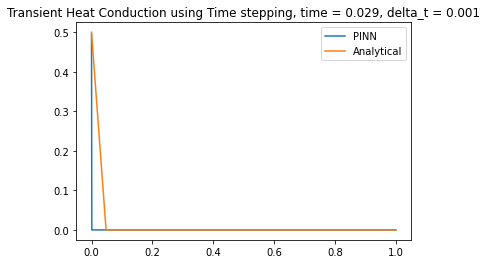

In [9]:
for i in range(N_t):
    for j in range(N_x_test):
        if(x_test_np[j]>s_store_pred[i]):
            T_store_pred[i][j][0] = T_r

j = 29
plt.plot(x_test_np, T_store_pred[j])
plt.plot(x_test_np, T_store_an[j])
Title = "Transient Heat Conduction using Time stepping, " + "time = " + str(j*del_t) + ", delta_t = " + str(del_t)
plt.title(Title)
plt.legend(["PINN", "Analytical"])
plt.show()